# Dimensionality reduction using genetic programming

The goal is the reduce the dimensions of data, so it can be displayed on scatter plot.

In [2]:
import operator
import math
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms, base, creator, tools, gp
from sklearn import datasets
from scipy import stats
from scipy import special
from scipy.spatial.distance import pdist

%matplotlib inline

In [3]:
warnings.filterwarnings("error")

In [4]:
iris = datasets.load_iris()

In [5]:
def create_list(first, last):
    return [first, last]

init_pset = gp.PrimitiveSet('INIT', 4)
init_pset.addPrimitive(create_list, 2)

In [6]:
def protected_div(left, right):
    try:
        return left / right
    except:
        return 1

work_pset = gp.PrimitiveSet('MAIN', 4)
work_pset.addPrimitive(operator.add, 2)
work_pset.addPrimitive(operator.sub, 2)
work_pset.addPrimitive(operator.mul, 2)
work_pset.addPrimitive(protected_div, 2)
work_pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

In [7]:
full_pset = gp.PrimitiveSet('FULL', 4)
full_pset.addPrimitive(operator.add, 2)
full_pset.addPrimitive(operator.sub, 2)
full_pset.addPrimitive(operator.mul, 2)
full_pset.addPrimitive(create_list, 2)
full_pset.addPrimitive(protected_div, 2)
full_pset.addEphemeralConstant("rand1012", lambda: random.randint(-1,1))

In [8]:
def pajchel():
    tree = gp.genHalfAndHalf(work_pset, min_=1, max_=2)
    tree[0] = init_pset.mapping['create_list']
    return tree

In [9]:
def mutate_pajchel(tree):
    mutated = gp.mutUniform(tree, toolbox.expr_mut, pset=work_pset)
    
    try:
        mutated[0][0] = init_pset.mapping['create_list']
    except ValueError as e:
        mutated = (creator.Individual(pajchel()),)

    return mutated

In [10]:
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.FitnessMin)

In [11]:
toolbox = base.Toolbox()
toolbox.register('expr', pajchel)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=full_pset)

def evalSymbReg(individual, points):
    func = toolbox.compile(expr=individual)
    
    reduced = [func(*x) for x in points]
    
    dist = pdist(reduced, metric='euclidean')
    
    h = np.histogram(dist)
    p=h[0].astype(float)/h[0].sum()
    return stats.entropy(p),
    


toolbox.register("evaluate", evalSymbReg, points=iris.data)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register('mutate', mutate_pajchel)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [12]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [16]:
pop = toolbox.population(n=400)
hof = tools.HallOfFame(5)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                                   halloffame=hof, verbose=True)

   	      	            fitness             	              size             
   	      	--------------------------------	-------------------------------
gen	nevals	avg   	max    	min	std     	avg  	max	min	std    
0  	400   	1.9031	2.17107	0  	0.422716	4.535	7  	3  	1.79827
1  	228   	2.02013	2.19726	0  	0.328948	4.485	11 	3  	1.90913
2  	200   	2.09062	2.19726	0  	0.191259	4.25 	13 	3  	1.87016
3  	228   	2.06101	2.19726	0  	0.318846	4.165	13 	3  	1.96285
4  	219   	2.08802	2.19726	1.59542	0.172571	3.85 	13 	3  	1.74284
5  	255   	2.0817 	2.19726	1.58525	0.177674	3.71 	15 	3  	1.648  
6  	229   	2.09696	2.19726	0      	0.192657	3.63 	13 	3  	1.4977 
7  	194   	2.08735	2.19726	0      	0.203057	3.85 	13 	3  	1.59922
8  	223   	2.0744 	2.19726	1.43545	0.193376	4.085	11 	3  	1.52078
9  	222   	2.12463	2.20631	1.59159	0.138037	4.455	11 	3  	1.5978 
10 	222   	2.12641	2.20631	0      	0.175062	4.915	13 	3  	1.59461
11 	210   	2.13221	2.20631	1.56171	0.142923	5.2  	13 	3  	1.69115
12 	235   	2

In [19]:
str(hof[1])

'create_list(add(protected_div(ARG2, ARG0), add(ARG3, sub(ARG0, ARG0))), ARG1)'

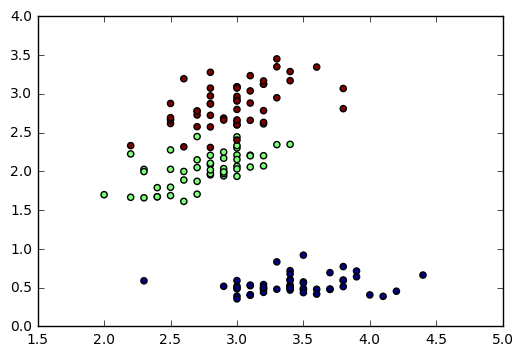

In [26]:
# plot the results
# najprv vytvorime redukovane data
func = toolbox.compile(hof[0])
reduced_data = [func(*x) for x in iris.data]
np_reduced_data = np.array(reduced_data)

fig, ax = plt.subplots(1,1)
ax.scatter(np_reduced_data[:,0], np_reduced_data[:,1], c=iris.target)

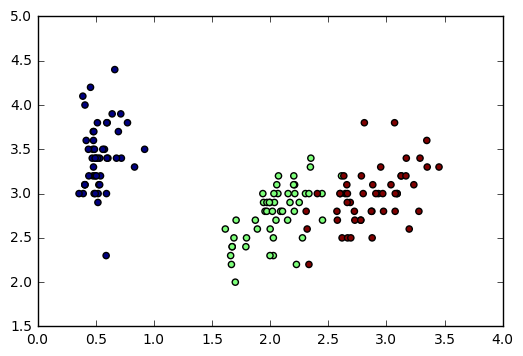

In [27]:
# plot the results
# najprv vytvorime redukovane data
func = toolbox.compile(hof[1])
reduced_data = [func(*x) for x in iris.data]
np_reduced_data = np.array(reduced_data)

fig, ax = plt.subplots(1,1)
ax.scatter(np_reduced_data[:,0], np_reduced_data[:,1], c=iris.target)